In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import clip
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Dataset**

In [2]:
from VQA_Dataset import VQA_Dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dataset = VQA_Dataset()
dataset.load_all(preprocess, length=200, device=device)

#Testing dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

for element in tqdm(dataloader, desc="Testing"):
    id = element['image_id']
    if id == 26216:
        print(element["question"])#, "question: ", i['question_tokens'], "answer: ", i['answer_tokens'])

Testing: 100%|██████████| 200/200 [00:00<00:00, 5403.99it/s]

['Is the man tell the girl to slide down?']
["Is the man old enough to be the girl's grandfather?"]
['What color is the slide?']


**Test-train split**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train size:  160
Test size:  20


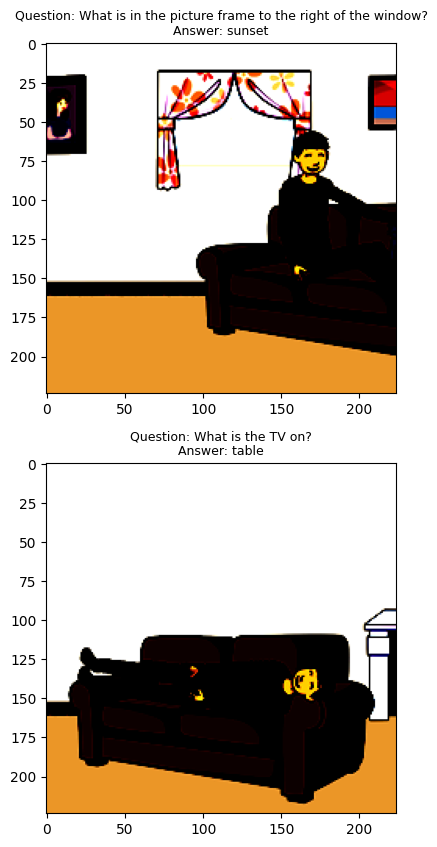

In [3]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.8)
val_size = int(len(dataset)*0.1)
test_size = int(len(dataset))-train_size-val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print("Train size: ", train_size)
print("Test size: ", test_size)

batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#Checking data
fig=plt.figure(0, (18, 10))
for element in train_dataloader:
    for i in range(batch_size):
        ax = fig.add_subplot(2,int(batch_size/2),i+1)
        
        ax.imshow(np.transpose(element["image"][i].squeeze(0).cpu(), (1, 2, 0))) #Converting to matplotlib format
        ax.set_title("Question: "+str(element["question"][i])+"\nAnswer: "+str(element["correct_answer_text"][i]), fontsize=9)
    break

**Model**

In [4]:
from models import VQA_Model2

#CLIP
clip_model, preprocess = clip.load('ViT-B/32', device)
vqa_model = VQA_Model2(clip_model, device)

# Freezing clip model: Without this, gradients scales were different (clip and mlp gradients), generated exploding gradient 
for param in vqa_model.model.parameters():
    param.requires_grad = False

In [5]:
import os
from PIL import Image
from torchvision import transforms

img = Image.open(os.path.join("Images", "abstract_v002_val2015_000000029903.png"))
image_input = preprocess(img).unsqueeze(0).to(device)
print("Image preprocessed: ",image_input.shape)

image_features = clip_model.encode_image(image_input)
print("Image encoded size: ", image_features.shape)

text = clip.tokenize(["a diagram of the dof" , "a dog", "a cat"]).to(device)
print("Text tokenized size: ",text.shape)

text_features = clip_model.encode_text(text)
print("Text encoded size: ",text_features.shape)

Image preprocessed:  torch.Size([1, 3, 224, 224])
Image encoded size:  torch.Size([1, 512])
Text tokenized size:  torch.Size([3, 77])
Text encoded size:  torch.Size([3, 512])


**Optim**

In [6]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
clip_value = 1.0
learning_rate = 1e-4
optimizer = torch.optim.Adam(vqa_model.parameters(), lr=learning_rate)


In [7]:
def train(dataloader, vqa_model, loss_function, optimizer, clip_value):
    size = len(dataloader.dataset)
    vqa_model.train()

    for batch, (data) in enumerate(dataloader):    
        images = data["image"].squeeze(1)
        question_tokens = data["question_tokens"].squeeze(1)
        answer_tokens = data["answer_tokens"].squeeze(1)
        similarity_pred = vqa_model(images, question_tokens, answer_tokens)

        similarity_label_arg = data["correct_answer_idx"].to(device)
        
        loss = loss_function(similarity_pred, similarity_label_arg)

        # #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value, error_if_nonfinite=True)

        optimizer.step()

        if batch % 10 ==0:
            loss, current = loss.item(), batch*len(images)
            print("loss: ", loss, current, size)

In [8]:
def eval(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader:    
            images = data["image"].squeeze(1)
            question_tokens = data["question_tokens"].squeeze(1)
            answer_tokens = data["answer_tokens"].squeeze(1)
            similarity_pred = vqa_model(images, question_tokens, answer_tokens)

            similarity_label_arg = torch.tensor(data["correct_answer_idx"]).unsqueeze(0).to(device)
            
            val_loss += loss_function(similarity_pred, similarity_label_arg)
            correct += (similarity_pred.argmax(1) == similarity_label_arg).type(torch.float).sum().item()
            
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

In [9]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, vqa_model, loss_fn, optimizer, clip_value)
    eval(val_dataset, vqa_model, loss_fn)

Epoch 1
-------------------------------
loss:  1.7393922805786133 0 160
loss:  4.037878036499023 20 160
loss:  4.452497959136963 40 160
loss:  3.733302116394043 60 160
loss:  1.3851478099822998 80 160
loss:  4.060832500457764 100 160
loss:  0.9420811533927917 120 160
loss:  4.505199432373047 140 160
Test Error: 
 Accuracy: 2.0%, Avg loss: 2.904904 

Epoch 2
-------------------------------
loss:  0.7368376851081848 0 160
loss:  1.363562822341919 20 160
loss:  1.6400216817855835 40 160
loss:  2.498716115951538 60 160
loss:  2.1552481651306152 80 160
loss:  2.0655078887939453 100 160
loss:  1.7531774044036865 120 160
loss:  0.7035439610481262 140 160
Test Error: 
 Accuracy: 2.5%, Avg loss: 2.760512 

Epoch 3
-------------------------------
loss:  1.4291108846664429 0 160
loss:  1.1355271339416504 20 160
loss:  1.5929956436157227 40 160
loss:  0.6058142781257629 60 160
loss:  0.7726273536682129 80 160
loss:  0.24440614879131317 100 160
loss:  3.0545060634613037 120 160
loss:  0.59550917148